# Load Libaries

In [0]:
import pathlib
from google.colab import drive

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
import h5py

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# tensorflow
import tensorflow as tf

# import Keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import optimizers
from keras import backend as K
from keras import regularizers

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


# PYTORCH 
import torch
import torchvision
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

%matplotlib inline

# Load Data

In [0]:
drive.mount('/content/drive')

my_data_dir = '/content/drive/My Drive/6874_FinalProject/data_AML/'

data_dir = pathlib.Path(my_data_dir)

# global variables
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
BATCH_SIZE = 18287
IMG_HEIGHT = 200
IMG_WIDTH = 200

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

In [0]:
X, class_label = next(train_data_gen)
X = tf.image.rgb_to_grayscale(X)

# Autoencoder 1

In [0]:
input_img_1 = Input(shape=(200, 200, 1))  # adapt this if using `channels_first` image data format

x_1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(0.001))(input_img_1)
x_1 = MaxPooling2D((2, 2), padding='same')(x_1)
x_1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(0.001))(x_1)
x_1 = MaxPooling2D((2, 2), padding='same')(x_1)
x_1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(0.001))(x_1)
x_1 = MaxPooling2D((2, 2), padding='same')(x_1)
x_1 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(0.001))(x_1)

encoded_1 = MaxPooling2D((2, 2), padding='same', name='encoded')(x_1)

# at this point the representation is (13, 13, 8) i.e. 1352-dimensional

x_1 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(0.001))(encoded_1)
x_1 = UpSampling2D((2, 2))(x_1)
x_1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(0.001))(x_1)
x_1 = UpSampling2D((2, 2))(x_1)
x_1 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.001))(x_1)
x_1 = UpSampling2D((2, 2))(x_1)
x_1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(0.001))(x_1)
x_1 = UpSampling2D((2, 2))(x_1)
decoded_1 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_regularizer=regularizers.l1(0.001))(x_1)

autoencoder_1 = Model(input_img_1, decoded_1)
autoencoder_1.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
# 10% testing data
x_train, x_test = tf.split(X, [16458, 1829], 0)

In [0]:
y_train, y_test = tf.split(class_label, [16458, 1829], 0)

In [0]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [0]:
# this current setup seems to create the best representations on the test set
autoencoder_1.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_split=0.1)

Train on 14812 samples, validate on 1646 samples
Epoch 1/20
14812/14812 [==============================] - 983s 66ms/step - loss: 1.7026 - val_loss: 1.1220
Epoch 2/20
14812/14812 [==============================] - 982s 66ms/step - loss: 0.8350 - val_loss: 0.6632
Epoch 3/20
14812/14812 [==============================] - 979s 66ms/step - loss: 0.6191 - val_loss: 0.5882
Epoch 4/20
14812/14812 [==============================] - 974s 66ms/step - loss: 0.5734 - val_loss: 0.5588
Epoch 5/20
14812/14812 [==============================] - 972s 66ms/step - loss: 0.5492 - val_loss: 0.5386
Epoch 6/20
14812/14812 [==============================] - 972s 66ms/step - loss: 0.5320 - val_loss: 0.5243
Epoch 7/20
14812/14812 [==============================] - 971s 66ms/step - loss: 0.5201 - val_loss: 0.5146
Epoch 8/20
14812/14812 [==============================] - 971s 66ms/step - loss: 0.5117 - val_loss: 0.5075
Epoch 9/20
14812/14812 [==============================] - 974s 66ms/step - loss: 0.5058 - val_l

## Plot Reconstructed Test Images

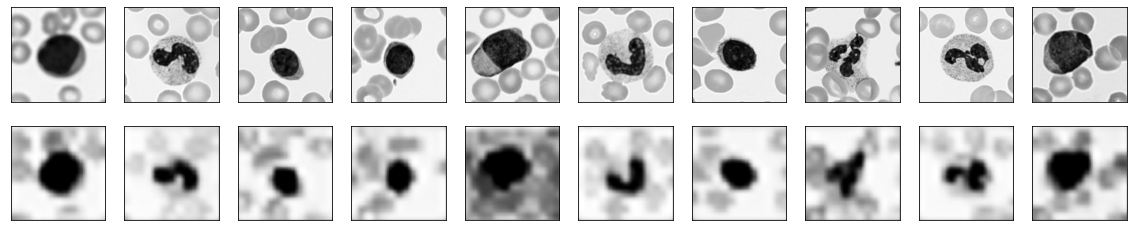

In [0]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(200, 200))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(200, 200))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Encode All Images

In [0]:
encoder = Model(inputs=autoencoder.input,
                        outputs=autoencoder.get_layer('encoded').output)

In [0]:
latent_pred_test = encoder.predict(x_test)
latent_pred_test_sh = np.reshape(latent_pred_test, [latent_pred_test.shape[0],latent_pred_test.shape[-1]*latent_pred_test.shape[-2]*latent_pred_test.shape[-3]])
y_test_cat = np.array(tf.argmax(y_test, axis=1))

In [0]:
latent_pred_train = encoder.predict(x_train)
latent_pred_train_sh = np.reshape(latent_pred_train, [latent_pred_train.shape[0],latent_pred_train.shape[-1]*latent_pred_train.shape[-2]*latent_pred_train.shape[-3]])
y_train_cat = np.array(tf.argmax(y_train, axis=1))

In [0]:
# save all X, y encoded
np.savetxt("/content/drive/My Drive/6874_FinalProject/data_AML/latent_test.txt", latent_pred_test_sh)
np.savetxt("/content/drive/My Drive/6874_FinalProject/data_AML/y_test.txt", y_test_cat)
np.savetxt("/content/drive/My Drive/6874_FinalProject/data_AML/latent_train.txt", latent_pred_train_sh)
np.savetxt("/content/drive/My Drive/6874_FinalProject/data_AML/y_train.txt", y_train_cat)

In [0]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("/content/drive/My Drive/6874_FinalProject/autoencoder_large.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("/content/drive/My Drive/6874_FinalProject/autoencoder_large.h5")
print("Saved model to disk")

# t-SNE 

In [0]:
# potentially incorporate PCA
pca_test_latent = PCA(n_components=10).fit_transform(latent_pred_test_sh)

In [0]:
X_embedded = TSNE(n_components=2, 
                  perplexity=30.0, 
                  learning_rate=.5, 
                  n_iter=10000, 
                  n_iter_without_progress=1000,
                  min_grad_norm=1e-12,
                  metric='sqeuclidean').fit_transform(latent_pred_test_sh)

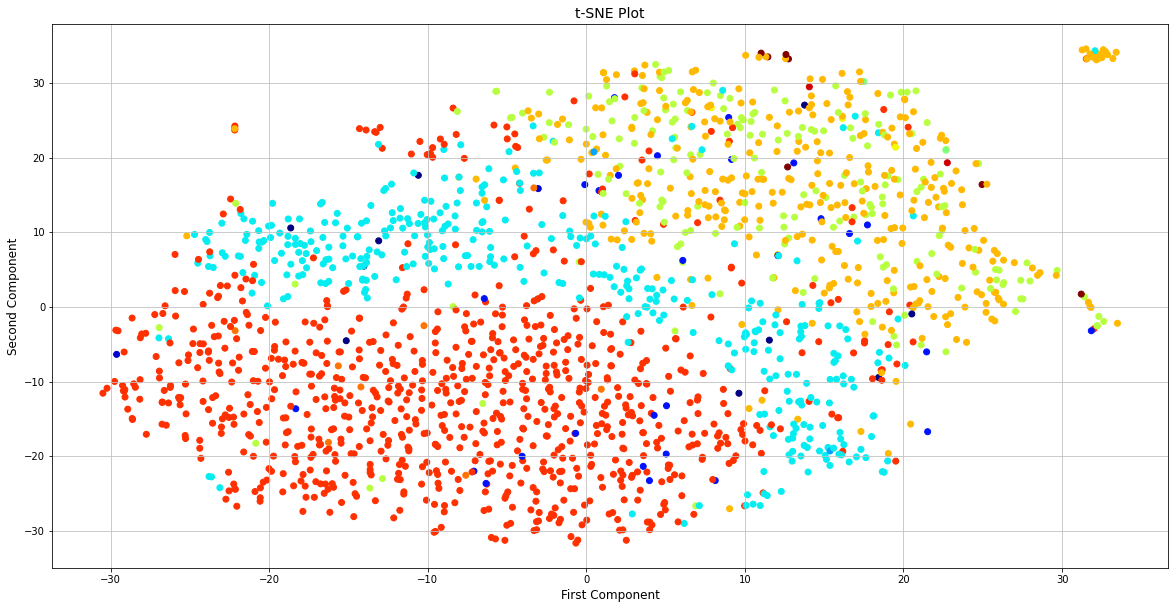

In [0]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_title("t-SNE Plot",fontsize=14)
ax.set_xlabel("First Component",fontsize=12)
ax.set_ylabel("Second Component",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=y_test_cat, marker = 'o', cmap = cm.jet);
plt.show()